In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import os, sys, re, pickle, glob
import urllib.request
import zipfile
from pathlib import Path

import IPython.display as ipd
from tqdm import tqdm
import librosa

# Elliot Linsey : 210764484 : Advanced Solution

We have been provided with a dataset containing audio files of either hums or whistles of recognisable songs or pieces of music. The purpose of this advanced solution is to create a machine learning pipeline that can predict whether an audio file fed into it is one of a number of pieces of music, these being themes from:
* The Lion King
* The Greatest Showman
* Star Wars
* Frozen
* Singing in the Rain
* Harry Potter
* The Pink Panther
* Mamma Mia

An interesting aspect of this particular dataset and problem in general, is that we do not have equal numbers of hums or whistles with there being far more hums in the dataset. Depending on what features we extract from the data, this may have an effect on our ability to predict what tune is being played.  

## Pipeline Description and Methodology

The pipeline will consist of an input stage, a transformation stage, feature extraction stage and a modelling stage leading to a prediction as the output. For the dataset we have received, some data cleaning techniques were used to rename all files into a pattern of "Participant ID" - "Interpretation Type (Whistle or Hum)" - "Interpretation Number (1-4)" - "Song Title". 

The input stage will take the raw .wav audio file, the transformation stage will conert the wav file into a numpy array using librosa, then shorten it to 15 seconds from the first onset. The feature extraction stage will extract the spectral centroids from the audio file. The model that will be used is a Random Forest Classifier to attempt to separate the classes by this feature and make a prediction. In addition to this, we shall use gridsearch and cross validation to find the optimal parameters for this problem. 

To train the model, we shall split the dataset into training and testing sets, with 80% being used for training and 20% being used for testing. Then we will use gridsearch and cross validation to determine the optimal parameters for RFC on our dataset and apply it to our test dataset to generate an F1 score. 

To further our evaluation of the ML model, we shall generate a confusion matrix that details the true positive, false positive, true negative and false negative predictions. We shall also create a report detailing the precision and recall of our model predictions. 

## Transformation, Feature Extraction and Dataset

For this experiment I am using all the files from the available data which amounts to 3330 audiofiles, which amounts to approximately 420 per class. There are around 300 hums and 100 whistles in each folder, so hums are around 3 times more prevalent which may lead our classifier to skew more towards hums when being trained on the data. 

In [157]:
sample_path = '/Users/ellio/Documents/MLHW/All_1/*.wav'
files = glob.glob(sample_path)
len(files)

3330

Using pandas I create a reference dataframe that contains all the relevant metadata about the audiofiles, this will be used to generate the labels array by locating the file_id's corresponding song value. 

In [158]:
MLENDHW_table = [] 

for file in files:
    file_name = file.split('\\')[-1]
    participant_ID = file_name.split('_')[0]
    interpretation_type = file_name.split('_')[1]
    interpretation_number = file_name.split('_')[2]
    song = re.search("\w+?(?=\.wav)",file_name.split('_')[3]).group()
    MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id')
#len(MLENDHW_df[(MLENDHW_df['interpretation']=='hum')])
MLENDHW_df.head()

,participant,interpretation,number,song
file_id,,,,
S100_hum_1_Hakuna.wav,S100,hum,1,Hakuna
S100_hum_1_Potter.wav,S100,hum,1,Potter
S100_hum_1_Rain.wav,S100,hum,1,Rain
S100_hum_2_Frozen.wav,S100,hum,2,Frozen
S100_hum_2_Hakuna.wav,S100,hum,2,Hakuna


I use onset detect to find the time of the first sound input, this will be useful to trim down the audio files into the same length for comparison. 

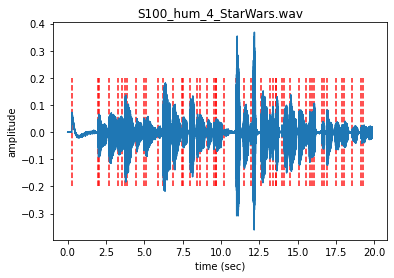

In [159]:
fs = None
n = 15
x, fs = librosa.load(files[n],sr=fs)
times = librosa.onset.onset_detect(y=x, sr=fs, units='time')
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.vlines(times, -0.20, 0.20,color='r', alpha=0.9,
           linestyle='--', label='Onsets')
title = files[n].split('\\')[-1]
plt.title(title)
plt.show()

Below I create a function that performs some data transformation. trim_audio() finds the first onset, essentially removing any silence at the beginning of the audio file, from here it takes the next 15 seconds of the track so that all subsequent arrays will be the same length for comparison. If the audiofile is less than 15 seconds, it appends 0s to the end of the file to pad the length. 

In [160]:
fs=None
x,fs=librosa.load(files[0],sr=fs)

def trim_audio(audiofile):
    times = librosa.onset.onset_detect(y=audiofile, sr=fs, units='time')
    t1 = int(times[0]*44100)
    t2 = t1+15*44100
    if len(audiofile[t1:t2])!=661500:
        audiofile = np.append(audiofile,[0]*(661500-len(audiofile[t1:t2])))
    return audiofile[t1:t2]

Using a file from the dataset, we can extract the spectral centroids into a numpy array. The length of this array is the number of spectral centroids and therefore the number of features to be used by the random forest classifier. At 1292, this is a lot of features and may lead to the model being at risk of overfitting. To combat this, I create a function mean_maker() that finds the mean centroid value for each second of audio, resulting in 15 features, however this may be less accurate than the original 1292. 

In [161]:
cent = librosa.feature.spectral_centroid(y=trim_audio(x), sr=fs, n_fft=7603)
print('Number of features = ' + str(len(cent[0])))

Number of features = 1292


In [162]:
def mean_maker(cent):
    lst = []
    lst2 = []
    x = 0
    for i in range(15):
        lst.append(cent[x:x+87])
        x+=87
    for x in lst:
        lst2.append(np.mean(x))
    return lst2
test = mean_maker(cent[0])
print('Reduced number of features = ' + str(len(test)))

Reduced number of features = 15


I also investigate the spectral centroids of the songs in the dataset. Below are the plotted representations of each different song titles' spectral centroid on a spectrogram. They are all taken from the same participant for comparison purposes. What we can see is that there are differences between each songs spectral centroids, however will the classifier be able to see each songs' pattern and make accurate predictions?

In [163]:
import librosa.display
def spectro(audiofile):
    title = audiofile.split('\\')[-1]
    fs=None
    audiofile,fs = librosa.load(audiofile,sr=fs)
    audiofile = trim_audio(audiofile)
    cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs, n_fft=7603)
    S, phase = librosa.magphase(librosa.stft(y=audiofile))
    librosa.feature.spectral_centroid(S=S)
    freqs, times, D = librosa.reassigned_spectrogram(audiofile, fill_nan=True)
    times = librosa.times_like(cent)
    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                             y_axis='log', x_axis='time',ax=ax,sr=fs,)
    ax.plot(times, cent.T, label='Spectral centroid', color='w',)
    ax.set_title(title)

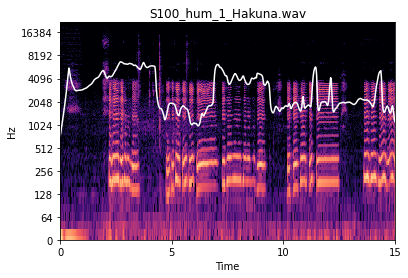

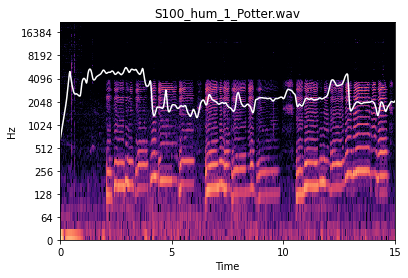

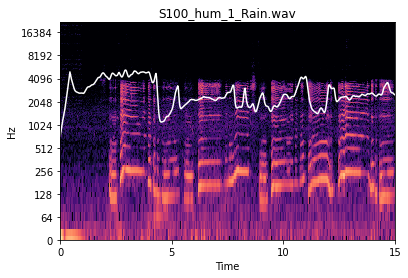

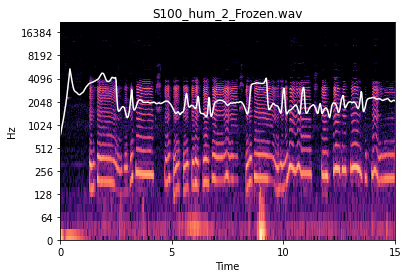

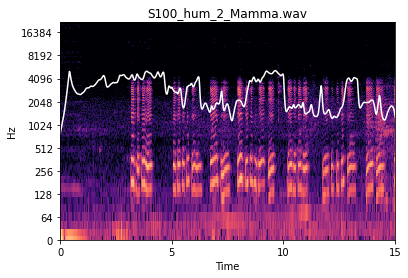

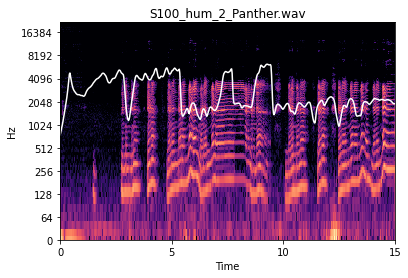

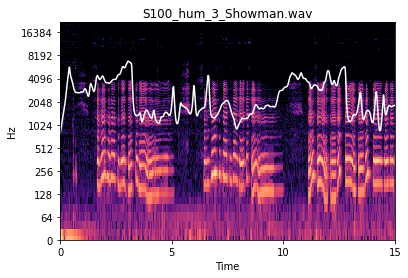

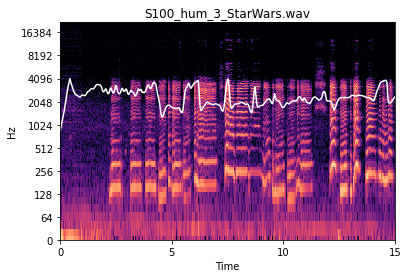

In [164]:
spectro(files[0])
spectro(files[1])
spectro(files[2])
spectro(files[3])
spectro(files[5])
spectro(files[6])
spectro(files[9])
spectro(files[10])

Below is another part of the feature extraction stage, the get_centroids() function loads the input wav file using librosa, then shortens it to 15 seconds using trim_audio, then it extracts the spectral centroids. Also within this function, it uses the previously created pandas dataframe to create the class array containing the labels of each file so that we can find how accurate our classifier is on a training and test dataset. 

The second version, get_centroids2(), utilises the previous function mean_maker() to reduce the number of features by finding the mean of the spectral centroids to result in 15 features. 

In [165]:
def labeler(fileID,labels_file=MLENDHW_df):
    if labels_file.loc[fileID]['song']=='Potter':
        return 'Potter'
    elif labels_file.loc[fileID]['song']=='StarWars':
        return 'StarWars'
    elif labels_file.loc[fileID]['song']=='Hakuna':
        return 'Hakuna'
    elif labels_file.loc[fileID]['song']=='Frozen':
        return 'Frozen'
    elif labels_file.loc[fileID]['song']=='Showman':
        return 'Showman'
    elif labels_file.loc[fileID]['song']=='Rain':
        return 'Rain'
    elif labels_file.loc[fileID]['song']=='Panther':
        return 'Panther'
    else:
        return 'Mamma'

# def labeler2(fileID,labels_file=MLENDHW_df):
#     if labels_file.loc[fileID]['interpretation']=='hum':
#         return False
#     else:
#         return True

In [166]:
def get_centroids(files, labels_file=MLENDHW_df):
    X = []
    y = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        X.append(cent)
        y.append(yi)
    return np.squeeze(np.array(X)),y

In [167]:
def get_centroids2(files, labels_file=MLENDHW_df):
    X = []
    y = []
    for file in tqdm(files):
        fileID = file.split('\\')[-1]
        file_name = file.split('\\')[-1]
        yi = labeler(fileID,labels_file=MLENDHW_df)
        #yi = labeler2(fileID,labels_file=MLENDHW_df)
        fs = None
        audiofile,fs = librosa.load(file,sr=fs)  
        audiofile = trim_audio(audiofile)
        cent = librosa.feature.spectral_centroid(y=audiofile, sr=fs)
        cent = mean_maker(cent[0])
        X.append(cent)
        y.append(yi)
    return np.squeeze(np.array(X)),y

Using the get_centroids function results in two numpy arrays, to avoid having to run it each time for the notebook we save them to .npy files and load them in. 

In [168]:
#X,y = get_centroids(files)
#X_2,y_2 = get_centroids2(files)
X = np.load('X_all.npy')
y = np.load('y_all.npy')
X_2 = np.load('X_means.npy')
y_2 = np.load('y_means.npy')

As we can see, the X matrix contains 3330 rows and 1292 columns (or features). Due to this, we are at a high risk of overfitting our data to the training set. 

In [169]:
X.shape

(3330, 1292)

## Experiment

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Splitting our data then fitting a baseline random forest classifier confirms our suspicions that we have overfit to our training data. We still achieve a test score of around 0.55 which is better than selecting a random choice. In this case, as we have 8 classes a random selection probability would be 1/8 or 0.125. Our test score is higher than this so we can infer that our base classifier has some ability to discern the classes and make the correct prediction. 

In [171]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('Train score = ' + str(clf.score(X_train,y_train)))
print('Test score = ' + str(clf.score(X_test,y_test)))
#clf.score(X_train,y_train)

Train score = 1.0
Test score = 0.5795795795795796


A clearer demonstration of the classifier is achieved by using a confusion matrix. As we can see from the diagonal line our predictor was able to recognise the classes to some degree, with all correct labels having been predicted the most out of each column. 

What we can also see is where our predictor went wrong, with Frozen being confused for Mamma and Rain the most, Hakuna also being confused for Rain and so on through the confusion matrix. This infers that, at least when using spectral centroids, there may be some overlap between these songs which cause difficulty in this specific random forest classifier to accurately differentiate them. 

In [172]:
from sklearn.metrics import confusion_matrix
X_predictions = clf.predict(X_test)
confusion = confusion_matrix(y_test,X_predictions)
confm = pd.DataFrame({
    'Pred. Frozen': confusion[:,0],
    'Pred. Hakuna': confusion[:,1],
    'Pred. Mamma': confusion[:,2],
    'Pred. Panther': confusion[:,3],
    'Pred. Potter': confusion[:,4],
    'Pred. Rain': confusion[:,5],
    'Pred. Showman': confusion[:,6],
    'Pred. StarWars': confusion[:,7],
}, index=['Act. Frozen','Act. Hakuna','Act. Mamma','Act. Panther',
         'Act. Potter','Act. Rain','Act. Showman','Act. StarWars',])
confm

,Pred. Frozen,Pred. Hakuna,Pred. Mamma,Pred. Panther,Pred. Potter,Pred. Rain,Pred. Showman,Pred. StarWars
Act. Frozen,43,2,9,8,3,6,3,5
Act. Hakuna,10,61,5,7,1,2,2,3
Act. Mamma,5,7,54,4,11,2,1,4
Act. Panther,6,2,5,60,10,2,2,4
Act. Potter,7,3,2,6,38,8,3,5
Act. Rain,5,1,6,1,8,41,8,3
Act. Showman,3,3,4,4,8,2,47,13
Act. StarWars,4,3,4,6,13,4,12,42


It is more useful to dive deeper into the results, rather than to just use overall accuracy. By calculating the precision and recall we can see how effective our model was at predicting each class. 

From below, we can see that the precision and recall varied quite signifantly between some of the classes. Using Mamma as an example, a 70% precision score means that for every Mamma prediction that the model made, 70% of them were truly Mamma with the other 30% being false positives. A 60% recall score means that for every actual Mamma, 60% of them were predicted Mamma and the other 40% were predicted another class. The Fscore is calculated from these two scores using the formula (2 * precision * recall)/(precision + recall) to give a single value that gives a measure of accuracy. The support is simply the number of occurrences of that label in the y label array. 

Some of the classes also have larger differences between their precision and recall scores which implies that, using Mamma as an example again, when we make a prediction that the song is Mamma, we can be 70% certain that it is true. However, we missed 60% of the actual Mamma songs when making our predictions and labelled them as false negatives. From these scores, we can say that our model is more effective at predicting some specific classes from the spectral centroids and that we can have more confidence with some predictions than others, for example we can have more trust in our classifier when it predicts Mamma (precision of 70%) compared to Frozen (precision of 50%). 

In [173]:
from sklearn.metrics import precision_recall_fscore_support
report = np.array(precision_recall_fscore_support(y_test,X_predictions))
class_report = pd.DataFrame({
    'Songs':['Frozen','Hakuna','Mamma','Panther','Potter','Rain','Showman','StarWars'],
    'Precision':report[0],
    'Recall':report[1],
    'Fscore':report[2],
    'Support':report[3],
}).set_index('Songs')
class_report

,Precision,Recall,Fscore,Support
Songs,,,,
Frozen,0.518072,0.544304,0.530864,79.0
Hakuna,0.743902,0.670330,0.705202,91.0
Mamma,0.606742,0.613636,0.610169,88.0
Panther,0.625000,0.659341,0.641711,91.0
Potter,0.413043,0.527778,0.463415,72.0
Rain,0.611940,0.561644,0.585714,73.0
Showman,0.602564,0.559524,0.580247,84.0
StarWars,0.531646,0.477273,0.502994,88.0


Using the reduced X matrix with only 15 features gives a similar test score to the full matrix above with 1292. As before, it is also highly overfitted. Using a gridsearch and cross validation on 1292 features takes a very long time and high processing power, therefore we fit the gridsearch to the reduced dataset to see if results can be improved. 

In [176]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X_2,y_2,test_size=0.2)
clf.fit(X_train2,y_train2)
clf.score(X_test2,y_test2)

0.5630630630630631

In [177]:
tuned_parameters = [
    {'max_depth': [5,10,15,20,25], 'n_estimators': [100,200,300,500,1000], 'max_features':['auto','sqrt']}
]
clf_cv = GridSearchCV(clf, tuned_parameters, cv=5, return_train_score=True)
clf_cv.fit(X_train2,y_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [5, 10, 15, 20, 25],
                          'max_features': ['auto', 'sqrt'],
                          'n_estimators': [100, 200, 300, 500, 1000]}],
             return_train_score=True)

In [185]:
print('Best hyperparameter settings: {0}.'.format(clf_cv.best_params_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(clf_cv.best_score_))
print('Train dataset accuracy of best hyperparameter setting: {0}.'.format(clf_cv.score(X_train2, y_train2)))
print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(clf_cv.score(X_test2, y_test2)))
clf_cv.best_estimator_

Best hyperparameter settings: {'max_depth': 15, 'max_features': 'auto', 'n_estimators': 1000}.
Average accuracy across folds of best hyperparameter setting: 0.5439094923048711.
Train dataset accuracy of best hyperparameter setting: 1.0.
Test dataset accuracy of best hyperparameter setting: 0.5705705705705706.


RandomForestClassifier(max_depth=15, n_estimators=1000)

The gridsearch has a negligible impact on the classifier scores and the confusion matrix and class report also look similar to the previous tables with the classifier still identifying some patterns, but getting confused between some songs. 

In [182]:
clf = RandomForestClassifier(max_depth = 15, max_features='auto', n_estimators = 1000)
clf.fit(X_train2,y_train2)
X_predictions2 = clf.predict(X_test2)

In [183]:
confusion2 = confusion_matrix(y_test2,X_predictions2)
confm2 = pd.DataFrame({
    'Pred. Frozen': confusion2[:,0],
    'Pred. Hakuna': confusion2[:,1],
    'Pred. Mamma': confusion2[:,2],
    'Pred. Panther': confusion2[:,3],
    'Pred. Potter': confusion2[:,4],
    'Pred. Rain': confusion2[:,5],
    'Pred. Showman': confusion2[:,6],
    'Pred. StarWars': confusion2[:,7],
}, index=['Act. Frozen','Act. Hakuna','Act. Mamma','Act. Panther',
         'Act. Potter','Act. Rain','Act. Showman','Act. StarWars',])
confm2

,Pred. Frozen,Pred. Hakuna,Pred. Mamma,Pred. Panther,Pred. Potter,Pred. Rain,Pred. Showman,Pred. StarWars
Act. Frozen,51,4,6,4,6,6,3,8
Act. Hakuna,7,46,5,1,1,6,2,6
Act. Mamma,3,4,51,6,5,3,0,11
Act. Panther,1,1,3,65,9,5,1,3
Act. Potter,7,2,5,6,37,6,5,5
Act. Rain,18,7,12,1,12,39,2,2
Act. Showman,6,1,4,3,4,3,44,24
Act. StarWars,5,4,5,0,10,2,12,40


In [184]:
report2 = np.array(precision_recall_fscore_support(y_test2,X_predictions2))
class_report2 = pd.DataFrame({
    'Songs':['Frozen','Hakuna','Mamma','Panther','Potter','Rain','Showman','StarWars'],
    'Precision':report2[0],
    'Recall':report2[1],
    'Fscore':report2[2],
    'Support':report2[3],
}).set_index('Songs')
class_report2

,Precision,Recall,Fscore,Support
Songs,,,,
Frozen,0.520408,0.579545,0.548387,88.0
Hakuna,0.666667,0.621622,0.643357,74.0
Mamma,0.560440,0.614458,0.586207,83.0
Panther,0.755814,0.738636,0.747126,88.0
Potter,0.440476,0.506849,0.471338,73.0
Rain,0.557143,0.419355,0.478528,93.0
Showman,0.637681,0.494382,0.556962,89.0
StarWars,0.404040,0.512821,0.451977,78.0


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
# clf = RandomForestClassifier()
# clf.fit(X_train,y_train)
# clf.score(X_test,y_test)
# #clf.score(X_train,y_train)

In [ ]:
# param_grid = {'max_depth': [3, 5, 10],
#              'min_samples_split': [2, 5, 10]}

In [ ]:
# clf_cv = GridSearchCV(clf, param_grid, cv=5)
# clf_cv.fit(X_train,y_train)
# print('Best hyperparameter settings: {0}.'.format(clf_cv.best_params_))
# print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(clf_cv.best_score_))
# print('Test dataset accuracy of best hyperparameter setting: {0}.'.format(clf_cv.score(X_test, y_test)))